## Fast.ai Deep Learning 1 Practice - BIWI head pose dataset

This notebook is practice for Lesson 3 of the [Fast.ai](https://www.fast.ai) course. It uses the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db).

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *

In [7]:
path = Path('/media/veracrypt3/Cloud/Datasets/biwi_head_pose/')

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6);
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [10]:
fname = '09/frame_00667_rgb.jpg'

In [11]:
def img2txt_name(f):
    return path/f'{str(f)[:-7]}pose.txt'

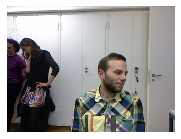

In [12]:
img = open_image(path/fname)
img.show()

In [13]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

In [14]:
get_ctr(fname)

tensor([263.9104, 428.5814])

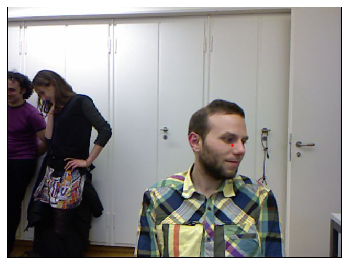

In [15]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

In [16]:
data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(), tfm_y=True, size=(120,160))
       .databunch().normalize(imagenet_stats)
       )

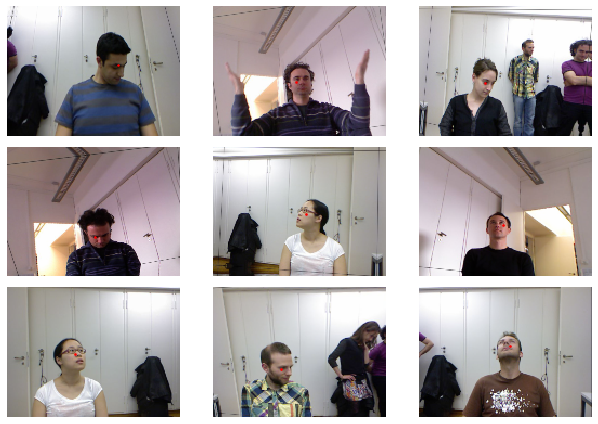

In [17]:
data.show_batch(3, figsize=(9, 6))

In [18]:
learn = cnn_learner(data, models.resnet34)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


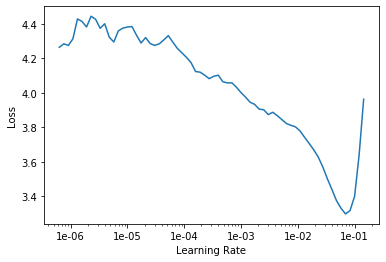

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 2e-2

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.127797,0.003860,00:39
1,0.044394,0.006966,00:39
2,0.015217,0.003691,00:39
3,0.008398,0.002318,00:39
4,0.006365,0.001408,00:39


In [22]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

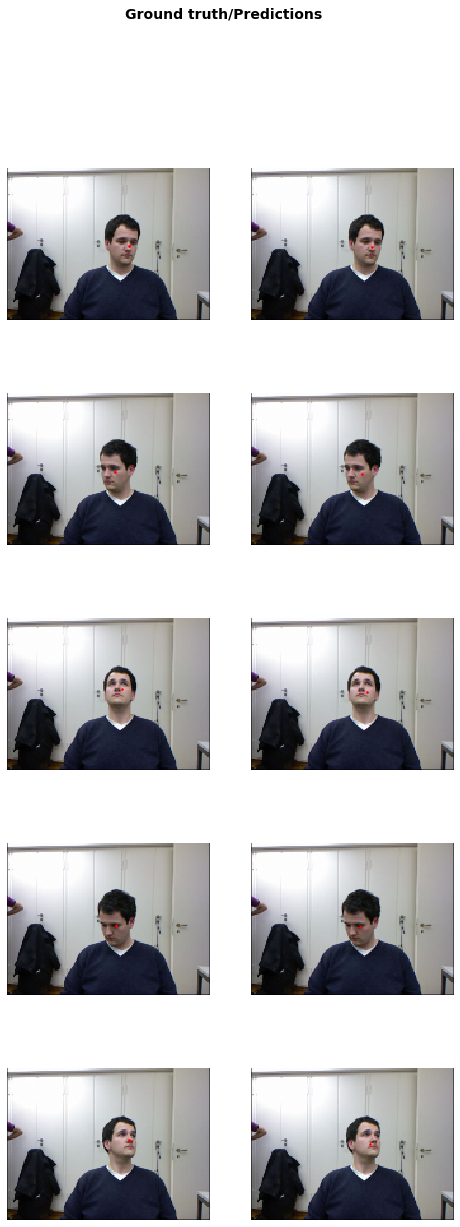

In [25]:
learn.show_results()

Data Augmentation

In [27]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(tfms, tfm_y=True, size=(120,160))
       .databunch().normalize(imagenet_stats)
       )

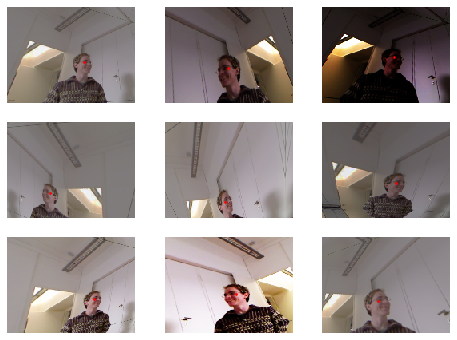

In [28]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,6))